# BigQuery extraction
This notebook contains code to download genetic variants in GPCR gene regions from gnomAD v2.1.1 hosted on Google BigQuery

In [15]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery

In [2]:
# Setup BigQuery client and convenience function
client = bigquery.Client()

def run_query(query):
    query_job = client.query(query)
    result = query_job.to_dataframe()
    gb_processed = (query_job.total_bytes_billed / 1024 ** 3)
    print(
        'This query processed {} GB of data which is {}% of your 1 TB monthly free quota.'.format(
            gb_processed, round(gb_processed / 1024 * 100, 4)
        )
    )
    return result

In [3]:
# Query to generate table of column info for the gnomAD variant table
query_template = """
SELECT column_name, field_path, description
FROM `bigquery-public-data`.gnomAD.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE table_name = "{GNOMAD_VER}__{CHROM}"
      AND column_name IN (
          SELECT COLUMN_NAME
          FROM `bigquery-public-data`.gnomAD.INFORMATION_SCHEMA.COLUMNS
          WHERE table_name = "{GNOMAD_VER}__{CHROM}")
"""
query = query_template.format(
    GNOMAD_VER='v2_1_1_exomes',
    CHROM='chr21'
)

column_info = run_query(query)
print(
    'There are {} columns in `bigquery-public-data.gnomAD.{}__{}` table'.format(
        len(column_info.index),
        'v2_1_1_exomes',
        'chr21'
    )
)
column_info.to_csv('../data/gnomad_v2_1_1_exomes_column_info.csv')

This query processed 0.01953125 GB of data which is 0.0019% of your 1 TB monthly free quota.
There are 950 columns in `bigquery-public-data.gnomAD.v2_1_1_exomes__chr21` table


In [4]:
# Load table of GPCR gene regions, extracted from Ensembl
gpcr_gene_regions = pd.read_csv('../data/Ensembl_Grch37_gpcr_genome_locations.csv')
gpcr_gene_regions

,HGNC symbol,HGNC name,HGNC id,Ensembl Id Grch38,Grch37 symbol,Grch37 chromosome,Grch37 start bp,Grch37 end bp,Human genetic localisation
0,ACKR1,atypical chemokine receptor 1 (Duffy blood group),4035,ENSG00000213088,DARC,1,159173097,159176290,1q23.2
1,ACKR2,atypical chemokine receptor 2,1565,ENSG00000144648,ACKR2,3,42846244,42929466,3p22.1
2,ACKR3,atypical chemokine receptor 3,23692,ENSG00000144476,ACKR3,2,237476430,237491001,2q37.3
3,ACKR4,atypical chemokine receptor 4,1611,ENSG00000129048,ACKR4,3,132316081,132337811,3q22.1
4,ADCYAP1R1,ADCYAP receptor type I,242,ENSG00000078549,ADCYAP1R1,7,31092076,31151089,7p14.3
...,...,...,...,...,...,...,...,...,...
388,TSHR,thyroid stimulating hormone receptor,12373,ENSG00000165409,TSHR,14,81421333,81612646,14q24-q31
389,UTS2R,urotensin 2 receptor,4468,ENSG00000181408,UTS2R,17,80332153,80333462,17q25.3
390,VIPR1,vasoactive intestinal peptide receptor 1,12694,ENSG00000114812,VIPR1,3,42530791,42579059,3p22.1
391,VIPR2,vasoactive intestinal peptide receptor 2,12695,ENSG00000106018,VIPR2,7,158820866,158937649,7q36.3


In [60]:
# Query to extract genetic variants in region
# NOTE: For v2_1_1 the "variant_type" column must be replaced with "alternate_bases.allele_type AS variant_type"
def query_region(gene_symbol, chromosome, x, y, gnomad_version='v2_1_1_exomes'):
    # Adjust query based on version
    if gnomad_version.startswith('v3'):
      # Variant type (snv, indel, multi-snv, multi-indel, or mixed) is stored under difference columns in V2 and V3
        variant_type_col = 'variant_type'
        extra_columns = ''
    else:
        variant_type_col = 'alternate_bases. allele_type'
        # These vep columns only exist in V2
        extra_columns = 'vep.STRAND AS STRAND, vep.Protein_position AS Protein_pos,'
    # Set query
    query_template = """
    SELECT reference_name AS chromosome, 
           start_position AS genome_pos,
           names AS variant_id,
           reference_bases,
           alternate_bases.alt AS alternate_bases,
           AN AS allele_number,
           alternate_bases.AC AS allele_count,
           alternate_bases.nhomalt AS num_alternate_homozygous,
           vep.Consequence AS vep_consequence,
           vep.IMPACT AS vep_impact,
           vep.SYMBOL AS vep_gene_symbol,
           vep.Gene AS vep_ensembl_gene,
           vep.Feature AS vep_ensembl_transcript,
           vep.ENSP AS vep_ensembl_protein,
           vep.Protein_position as vep_protein_pos,
           vep.Amino_acids as vep_amino_acids,
           vep.DISTANCE as vep_distance_to_transcript,
           vep.SWISSPROT as vep_swissprot_match,
           vep.SIFT as vep_SIFT,
           vep.PolyPhen as vep_PolyPhen
    FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
         main_table.alternate_bases AS alternate_bases,
         alternate_bases.vep AS vep
    WHERE start_position >= {X} AND start_position <= {Y} AND vep.SYMBOL = "{GENE}"
    ORDER BY 1,2
    """
    query = query_template.format(GNOMAD_VER=gnomad_version,
                                  CHROM=chromosome,
                                  GENE=gene_symbol,
                                  X=x, 
                                  Y=y
                                 )

    print(
        'Running Region (Type 1) queries on gnomAD version: {}, chromosome: {}, gene symbol: {}'.format(
            gnomad_version,
            chromosome,
            gene_symbol
        )
    )
    output = run_query(query)
    return output

In [61]:
# Test region query 
test_DARC = query_region('DARC','chr1','159173097','159176290')

Running Region (Type 1) queries on gnomAD version: v2_1_1_exomes, chromosome: chr1, gene symbol: DARC
This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.


In [62]:
# Check output of test query
test_DARC

,chromosome,genome_pos,variant_id,reference_bases,alternate_bases,allele_number,allele_count,num_alternate_homozygous,vep_consequence,vep_impact,vep_gene_symbol,vep_ensembl_gene,vep_ensembl_transcript,vep_ensembl_protein,vep_protein_pos,vep_amino_acids,vep_distance_to_transcript,vep_swissprot_match,vep_SIFT,vep_PolyPhen
0,1,159174698,[rs751332400],G,A,251396,4,0,upstream_gene_variant,MODIFIER,DARC,ENSG00000213088,ENST00000368121,ENSP00000357103,None,None,502.0,Q16570,None,None
1,1,159174698,[rs751332400],G,A,251396,4,0,5_prime_UTR_variant,MODIFIER,DARC,ENSG00000213088,ENST00000368122,ENSP00000357104,None,None,NaN,Q16570,None,None
2,1,159174698,[rs751332400],G,A,251396,4,0,upstream_gene_variant,MODIFIER,DARC,ENSG00000213088,ENST00000435307,ENSP00000398406,None,None,10.0,None,None,None
3,1,159174698,[rs751332400],G,A,251396,4,0,5_prime_UTR_variant,MODIFIER,DARC,ENSG00000213088,ENST00000537147,ENSP00000441985,None,None,NaN,Q16570,None,None
4,1,159174703,[rs1800846],C,G,251424,2,0,upstream_gene_variant,MODIFIER,DARC,ENSG00000213088,ENST00000368121,ENSP00000357103,None,None,497.0,Q16570,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,1,159176285,[rs571905908],G,T,196412,1,0,3_prime_UTR_variant,MODIFIER,DARC,ENSG00000213088,ENST00000537147,ENSP00000441985,None,None,NaN,Q16570,None,None
1572,1,159176288,[rs774224009],A,G,194216,1,0,downstream_gene_variant,MODIFIER,DARC,ENSG00000213088,ENST00000368121,ENSP00000357103,None,None,1.0,Q16570,None,None
1573,1,159176288,[rs774224009],A,G,194216,1,0,3_prime_UTR_variant,MODIFIER,DARC,ENSG00000213088,ENST00000368122,ENSP00000357104,None,None,NaN,Q16570,None,None
1574,1,159176288,[rs774224009],A,G,194216,1,0,downstream_gene_variant,MODIFIER,DARC,ENSG00000213088,ENST00000435307,ENSP00000398406,None,None,601.0,None,None,None


In [63]:
# Run query for all GPCRs in table
variants_by_gene = []
for i, row in gpcr_gene_regions.iterrows():
    variants = query_region(
        row['Grch37 symbol'],
        'chr'+row['Grch37 chromosome'],
        row['Grch37 start bp'],
        row['Grch37 end bp']
    )
    variants_by_gene.append(variants)

Running Region (Type 1) queries on gnomAD version: v2_1_1_exomes, chromosome: chr1, gene symbol: DARC
This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.
Running Region (Type 1) queries on gnomAD version: v2_1_1_exomes, chromosome: chr3, gene symbol: ACKR2
This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.
Running Region (Type 1) queries on gnomAD version: v2_1_1_exomes, chromosome: chr2, gene symbol: ACKR3
This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.
Running Region (Type 1) queries on gnomAD version: v2_1_1_exomes, chromosome: chr3, gene symbol: ACKR4
This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.
Running Region (Type 1) queries on gnomAD version: v2_1_1_exomes, chromosome: chr7, gene symbol: ADCYAP1R1
This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.
Running Region (Type 1) que

In [78]:
# Filter non-existent variants and annotate with up-to-date gene symbols
all_variants = pd.concat(variants_by_gene)
all_variants = all_variants[all_variants.allele_count > 0]
all_variants = gpcr_gene_regions[['HGNC symbol','HGNC name','Grch37 symbol']].merge(all_variants,left_on='Grch37 symbol',right_on='vep_gene_symbol')
all_variants

,HGNC symbol,HGNC name,Grch37 symbol,chromosome,genome_pos,variant_id,reference_bases,alternate_bases,allele_number,allele_count,...,vep_ensembl_gene,vep_ensembl_transcript,vep_ensembl_protein,vep_protein_pos,vep_amino_acids,vep_distance_to_transcript,vep_swissprot_match,vep_SIFT,vep_PolyPhen,Uniprot name
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174698,[rs751332400],G,A,251396,4,...,ENSG00000213088,ENST00000368122,ENSP00000357104,None,None,NaN,Q16570,None,None,ACKR1_HUMAN
5,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174703,[rs1800846],C,G,251424,2,...,ENSG00000213088,ENST00000368122,ENSP00000357104,None,None,NaN,Q16570,None,None,ACKR1_HUMAN
9,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174706,[rs774009195],C,T,251410,2,...,ENSG00000213088,ENST00000368122,ENSP00000357104,None,None,NaN,Q16570,None,None,ACKR1_HUMAN
13,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174707,[rs745541007],C,T,251440,17,...,ENSG00000213088,ENST00000368122,ENSP00000357104,None,None,NaN,Q16570,None,None,ACKR1_HUMAN
17,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174707,[rs745541007],C,G,251440,1,...,ENSG00000213088,ENST00000368122,ENSP00000357104,None,None,NaN,Q16570,None,None,ACKR1_HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048392,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063458,[rs568812959],C,T,228398,8,...,ENSG00000173578,ENST00000309285,ENSP00000310405,None,None,NaN,P46094,None,None,XCR1_HUMAN
1048395,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063459,[rs766170275],G,A,227994,2,...,ENSG00000173578,ENST00000309285,ENSP00000310405,None,None,NaN,P46094,None,None,XCR1_HUMAN
1048398,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063476,[rs751498207],T,A,211160,1,...,ENSG00000173578,ENST00000309285,ENSP00000310405,None,None,NaN,P46094,None,None,XCR1_HUMAN
1048401,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063479,[rs759318862],T,C,209512,2,...,ENSG00000173578,ENST00000309285,ENSP00000310405,None,None,NaN,P46094,None,None,XCR1_HUMAN


In [80]:
all_variants.to_csv('../data/gnomad_v2.1.1_gpcr_variants_unfiltered.csv')

# Filtering of variants

In [4]:
# Load variants; needs hacking for long dataframe
all_variants_begun = pd.read_csv('../data/gnomad_v2.1.1_gpcr_variants_unfiltered.csv',index_col=0,low_memory=False,nrows=1000000)
all_variants_continued = pd.read_csv('../data/gnomad_v2.1.1_gpcr_variants_unfiltered.csv',index_col=0,low_memory=False,skiprows=1000001,names=all_variants_begun.columns)
all_variants = pd.concat((all_variants_begun,all_variants_continued))                    
all_variants

,HGNC symbol,HGNC name,Grch37 symbol,chromosome,genome_pos,variant_id,reference_bases,alternate_bases,allele_number,allele_count,...,vep_ensembl_transcript,vep_ensembl_protein,vep_protein_pos,vep_amino_acids,vep_distance_to_transcript,vep_swissprot_match,vep_SIFT,vep_PolyPhen,Uniprot name,Ensembl transcript
0,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174698,['rs751332400'],G,A,251396,4,...,ENST00000368121,ENSP00000357103,NaN,NaN,502.0,Q16570,NaN,NaN,ACKR1_HUMAN,ENST00000368122
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174698,['rs751332400'],G,A,251396,4,...,ENST00000368122,ENSP00000357104,NaN,NaN,NaN,Q16570,NaN,NaN,ACKR1_HUMAN,ENST00000368122
2,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174698,['rs751332400'],G,A,251396,4,...,ENST00000435307,ENSP00000398406,NaN,NaN,10.0,NaN,NaN,NaN,ACKR1_HUMAN,ENST00000368122
3,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174698,['rs751332400'],G,A,251396,4,...,ENST00000537147,ENSP00000441985,NaN,NaN,NaN,Q16570,NaN,NaN,ACKR1_HUMAN,ENST00000368122
4,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174703,['rs1800846'],C,G,251424,2,...,ENST00000368121,ENSP00000357103,NaN,NaN,497.0,Q16570,NaN,NaN,ACKR1_HUMAN,ENST00000368122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048402,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063479,['rs759318862'],T,C,209512,2,...,ENST00000395946,ENSP00000379277,NaN,NaN,NaN,NaN,NaN,NaN,XCR1_HUMAN,ENST00000309285
1048403,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063479,['rs759318862'],T,C,209512,2,...,ENST00000542109,ENSP00000438119,NaN,NaN,NaN,P46094,NaN,NaN,XCR1_HUMAN,ENST00000309285
1048404,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063483,['rs767355373'],G,T,204936,3,...,ENST00000309285,ENSP00000310405,NaN,NaN,NaN,P46094,NaN,NaN,XCR1_HUMAN,ENST00000309285
1048405,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063483,['rs767355373'],G,T,204936,3,...,ENST00000395946,ENSP00000379277,NaN,NaN,NaN,NaN,NaN,NaN,XCR1_HUMAN,ENST00000309285


In [51]:
# Load transcripts that produce Uniprot canonical isoform
canonical_transcripts_uniprot = pd.read_csv('../../receptors/Uniprot_GPCR_canonical_transcripts.csv')
canonical_transcripts_uniprot

,HGNC symbol,Uniprot name,Canonical ensembl transcript
0,ACKR1,ACKR1_HUMAN,ENST00000368122
1,ACKR2,ACKR2_HUMAN,ENST00000422265
2,ACKR3,ACKR3_HUMAN,ENST00000272928
3,ACKR4,ACKR4_HUMAN,ENST00000249887
4,ADCYAP1R1,PACR_HUMAN,ENST00000304166
...,...,...,...
388,TSHR,TSHR_HUMAN,ENST00000298171
389,UTS2R,UR2R_HUMAN,ENST00000313135
390,VIPR1,VIPR1_HUMAN,ENST00000325123
391,VIPR2,VIPR2_HUMAN,ENST00000262178


In [52]:
# filter variants for ones that effect the canonical transcript
all_variants_filtered = all_variants.drop(
    ['Uniprot name','Ensembl transcript'],
    axis=1
)
all_variants_filtered = all_variants_filtered.merge(canonical_transcripts_uniprot, on='HGNC symbol')
all_variants_filtered = all_variants_filtered[all_variants_filtered['vep_ensembl_transcript']==all_variants_filtered['Canonical ensembl transcript']]
all_variants_filtered = all_variants_filtered.drop('Canonical ensembl transcript',axis=1)
all_variants_filtered

,HGNC symbol,HGNC name,Grch37 symbol,chromosome,genome_pos,variant_id,reference_bases,alternate_bases,allele_number,allele_count,...,vep_ensembl_gene,vep_ensembl_transcript,vep_ensembl_protein,vep_protein_pos,vep_amino_acids,vep_distance_to_transcript,vep_swissprot_match,vep_SIFT,vep_PolyPhen,Uniprot name
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174698,['rs751332400'],G,A,251396,4,...,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,NaN,NaN,Q16570,NaN,NaN,ACKR1_HUMAN
5,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174703,['rs1800846'],C,G,251424,2,...,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,NaN,NaN,Q16570,NaN,NaN,ACKR1_HUMAN
9,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174706,['rs774009195'],C,T,251410,2,...,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,NaN,NaN,Q16570,NaN,NaN,ACKR1_HUMAN
13,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174707,['rs745541007'],C,T,251440,17,...,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,NaN,NaN,Q16570,NaN,NaN,ACKR1_HUMAN
17,ACKR1,atypical chemokine receptor 1 (Duffy blood group),DARC,1,159174707,['rs745541007'],C,G,251440,1,...,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,NaN,NaN,Q16570,NaN,NaN,ACKR1_HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048392,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063458,['rs568812959'],C,T,228398,8,...,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,NaN,NaN,P46094,NaN,NaN,XCR1_HUMAN
1048395,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063459,['rs766170275'],G,A,227994,2,...,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,NaN,NaN,P46094,NaN,NaN,XCR1_HUMAN
1048398,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063476,['rs751498207'],T,A,211160,1,...,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,NaN,NaN,P46094,NaN,NaN,XCR1_HUMAN
1048401,XCR1,X-C motif chemokine receptor 1,XCR1,3,46063479,['rs759318862'],T,C,209512,2,...,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,NaN,NaN,P46094,NaN,NaN,XCR1_HUMAN


In [54]:
# filter missense variants
moderate_variants = all_variants_filtered[all_variants_filtered['vep_impact'] == 'MODERATE']
moderate_variants = moderate_variants[moderate_variants['vep_consequence'].str.contains('missense')]
moderate_variants['reference_amino_acid'] = moderate_variants['vep_amino_acids'].apply(lambda x: x.split('/')[0])
moderate_variants['alternate_amino_acid'] = moderate_variants['vep_amino_acids'].apply(lambda x: x.split('/')[1])
moderate_variants['vep_protein_pos'] = moderate_variants['vep_protein_pos'].astype(int)
moderate_variants = moderate_variants.reset_index()
moderate_variants = moderate_variants.drop([
    'index',
    'Grch37 symbol',
    'chromosome',
    'genome_pos',
    'reference_bases',
    'alternate_bases',
    'vep_impact',
    'vep_gene_symbol',
    'vep_distance_to_transcript',
    'vep_amino_acids',
    'Uniprot name'
    ],axis=1)
moderate_variants.columns = [
    'HGNC symbol',
    'HGNC name',
    'variant_id',
    'allele_number',
    'allele_count',
    'num_alternate_homozygous',
    'consequence',
    'ensembl_gene',
    'ensembl_transcript',
    'ensembl_protein',
    'protein_pos',
    'swissprot_match',
    'SIFT',
    'PolyPhen',
    'reference_amino_acid',
    'alternate_amino_acid'
]
moderate_variants = moderate_variants[[
    'HGNC symbol',
    'HGNC name',
    'ensembl_gene',
    'ensembl_transcript',
    'ensembl_protein',
    'swissprot_match',
    'variant_id',
    'protein_pos',
    'reference_amino_acid',
    'alternate_amino_acid',
    'consequence',
    'SIFT',
    'PolyPhen',
    'allele_number',
    'allele_count',
    'num_alternate_homozygous'
]]
moderate_variants.to_csv('../data/gnomad_v2.1.1_gpcr_variants_missense.csv')
moderate_variants

,HGNC symbol,HGNC name,ensembl_gene,ensembl_transcript,ensembl_protein,swissprot_match,variant_id,protein_pos,reference_amino_acid,alternate_amino_acid,consequence,SIFT,PolyPhen,allele_number,allele_count,num_alternate_homozygous
0,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs745464625'],3,N,S,missense_variant,tolerated(0.06),probably_damaging(0.987),251294,1,0
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs1297356885'],5,L,V,missense_variant,deleterious(0.01),probably_damaging(0.99),251250,1,0
2,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs763887810'],8,A,V,missense_variant&splice_region_variant,tolerated(1),benign(0.001),244322,5,0
3,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs369005597'],9,E,K,missense_variant,tolerated(0.8),benign(0.121),246306,1,0
4,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs531431646'],16,N,S,missense_variant,tolerated(0.17),possibly_damaging(0.689),250308,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102923,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs757344022'],12,F,L,missense_variant,tolerated(0.65),benign(0.009),250566,2,0
102924,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs778906589'],12,F,I,missense_variant,tolerated(0.39),benign(0.002),250508,1,0
102925,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs778906589'],12,F,V,missense_variant,tolerated(0.5),benign(0.003),250508,13,0
102926,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs1299692557'],2,E,D,missense_variant,tolerated(0.08),possibly_damaging(0.468),246062,3,0


In [55]:
# filter pLoF variants
high_variants = all_variants_filtered[all_variants_filtered['vep_impact'] == 'HIGH'].copy()

high_variants[['protein_pos_start','protein_pos_end']] = high_variants['vep_protein_pos'].str.split('-',expand=True)
high_variants[['reference_amino_acid','alternate_amino_acid']] = high_variants['vep_amino_acids'].str.split('/',expand=True)
high_variants = high_variants.reset_index()
high_variants = high_variants.drop([
    'index',
    'Grch37 symbol',
    'chromosome',
    'genome_pos',
    'reference_bases',
    'alternate_bases',
    'vep_impact',
    'vep_gene_symbol',
    'vep_distance_to_transcript',
    'vep_amino_acids',
    'vep_SIFT',
    'vep_PolyPhen',
    'vep_protein_pos',
    'Uniprot name'
     ],axis=1)
high_variants.columns = [
    'HGNC symbol',
    'HGNC name',
    'variant_id',
    'allele_number',
    'allele_count',
    'num_alternate_homozygous',
    'consequence',
    'ensembl_gene',
    'ensembl_transcript',
    'ensembl_protein',
    'swissprot_match',
    'protein_pos_start',
    'protein_pos_end',
    'reference_amino_acid',
    'alternate_amino_acid'
]
high_variants = high_variants[[
    'HGNC symbol',
    'HGNC name',
    'ensembl_gene',
    'ensembl_transcript',
    'ensembl_protein',
    'swissprot_match',
    'variant_id',
    'protein_pos_start',
    'protein_pos_end',
    'reference_amino_acid',
    'alternate_amino_acid',
    'consequence',
    'allele_number',
    'allele_count',
    'num_alternate_homozygous'
]]
high_variants.to_csv('../data/gnomad_v2.1.1_gpcr_variants_plof.csv')
high_variants

,HGNC symbol,HGNC name,ensembl_gene,ensembl_transcript,ensembl_protein,swissprot_match,variant_id,protein_pos_start,protein_pos_end,reference_amino_acid,alternate_amino_acid,consequence,allele_number,allele_count,num_alternate_homozygous
0,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs756754694'],1,None,M,V,start_lost,251376,2,0
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs768744460'],3,None,N,X,frameshift_variant,251342,1,0
2,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs748490259'],NaN,NaN,NaN,NaN,splice_donor_variant,251042,2,0
3,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs3027017'],59,60,DS,DX,frameshift_variant,251218,1,0
4,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs1319167975'],88,None,F,X,frameshift_variant,250802,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9025,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs761112616'],154,None,W,X,frameshift_variant,249262,1,0
9026,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs144371089'],145,146,CR,X,frameshift_variant,246972,2,0
9027,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs369074574'],135,None,L,X,frameshift_variant,243148,2,0
9028,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs781473412'],93,None,W,*,stop_gained,251324,3,0


In [56]:
# filter synonymous variants
synonymous_variants = all_variants_filtered[all_variants_filtered['vep_impact'] == 'LOW'].copy()
synonymous_variants = synonymous_variants[synonymous_variants['vep_consequence'].str.contains('synonymous')]
synonymous_variants['vep_protein_pos'] = synonymous_variants['vep_protein_pos'].astype(int)
synonymous_variants = synonymous_variants.reset_index()
synonymous_variants =synonymous_variants.drop([
    'index',
    'Grch37 symbol',
    'chromosome',
    'genome_pos',
    'reference_bases',
    'alternate_bases',
    'vep_impact',
    'vep_gene_symbol',
    'vep_distance_to_transcript',
    'vep_SIFT',
    'vep_PolyPhen',
    'Uniprot name'
    ],axis=1)
synonymous_variants.columns = [
    'HGNC symbol',
    'HGNC name',
    'variant_id',
    'allele_number',
    'allele_count',
    'num_alternate_homozygous',
    'consequence',
    'ensembl_gene',
    'ensembl_transcript',
    'ensembl_protein',
    'protein_pos',
    'amino_acid',
    'swissprot_match'
]
synonymous_variants = synonymous_variants[[
    'HGNC symbol',
    'HGNC name',
    'ensembl_gene',
    'ensembl_transcript',
    'ensembl_protein',
    'swissprot_match',
    'variant_id',
    'protein_pos',
    'amino_acid',
    'consequence',
    'allele_number',
    'allele_count',
    'num_alternate_homozygous'
]]
synonymous_variants.to_csv('../data/gnomad_v2.1.1_gpcr_variants_synonymous.csv')
synonymous_variants

,HGNC symbol,HGNC name,ensembl_gene,ensembl_transcript,ensembl_protein,swissprot_match,variant_id,protein_pos,amino_acid,consequence,allele_number,allele_count,num_alternate_homozygous
0,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs778295334'],2,G,synonymous_variant,251346,1,0
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs771832928'],3,N,synonymous_variant,251276,2,0
2,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs775346470'],6,H,synonymous_variant,251172,1,0
3,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs376855885'],8,A,splice_region_variant&synonymous_variant,245942,1,0
4,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs376855885'],8,A,splice_region_variant&synonymous_variant,245942,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52507,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs777901765'],13,F,synonymous_variant,250316,1,0
52508,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs1398615981'],11,T,synonymous_variant,250460,1,0
52509,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs1305516943'],9,S,synonymous_variant,250126,1,0
52510,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs745994520'],6,N,synonymous_variant,248548,2,0


In [57]:
# filter non-coding variants
modifier_variants = all_variants_filtered[all_variants_filtered['vep_impact'] == 'MODIFIER'].copy()
modifier_variants = modifier_variants.reset_index()
modifier_variants = modifier_variants.drop([
    'index',
    'Grch37 symbol',
    'chromosome',
    'genome_pos',
    'reference_bases',
    'alternate_bases',
    'vep_impact',
    'vep_gene_symbol',
    'vep_SIFT',
    'vep_PolyPhen',
    'vep_protein_pos',
    'vep_amino_acids',
    'Uniprot name'
    ],axis=1)
modifier_variants.to_csv('../data/gnomad_v2.1.1_gpcr_variants_modifier.csv')
modifier_variants

,HGNC symbol,HGNC name,variant_id,allele_number,allele_count,num_alternate_homozygous,vep_consequence,vep_ensembl_gene,vep_ensembl_transcript,vep_ensembl_protein,vep_distance_to_transcript,vep_swissprot_match
0,ACKR1,atypical chemokine receptor 1 (Duffy blood group),['rs751332400'],251396,4,0,5_prime_UTR_variant,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,Q16570
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),['rs1800846'],251424,2,0,5_prime_UTR_variant,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,Q16570
2,ACKR1,atypical chemokine receptor 1 (Duffy blood group),['rs774009195'],251410,2,0,5_prime_UTR_variant,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,Q16570
3,ACKR1,atypical chemokine receptor 1 (Duffy blood group),['rs745541007'],251440,17,1,5_prime_UTR_variant,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,Q16570
4,ACKR1,atypical chemokine receptor 1 (Duffy blood group),['rs745541007'],251440,1,0,5_prime_UTR_variant,ENSG00000213088,ENST00000368122,ENSP00000357104,NaN,Q16570
...,...,...,...,...,...,...,...,...,...,...,...,...
62589,XCR1,X-C motif chemokine receptor 1,['rs376028715'],231044,2,0,5_prime_UTR_variant,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,P46094
62590,XCR1,X-C motif chemokine receptor 1,['rs568812959'],228398,8,0,5_prime_UTR_variant,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,P46094
62591,XCR1,X-C motif chemokine receptor 1,['rs766170275'],227994,2,0,5_prime_UTR_variant,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,P46094
62592,XCR1,X-C motif chemokine receptor 1,['rs759318862'],209512,2,0,intron_variant,ENSG00000173578,ENST00000309285,ENSP00000310405,NaN,P46094


In [2]:
# Load all GPCR missense variants
missense_variants = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_missense.csv',index_col=0)
# Load residue labels for class A GPCRs
residue_labels_classA = pd.read_csv('../data/GPCRdb_residue_numbering/GPCRdb_generic_numbers_by_gpcr_residue_ClassA.csv')
missense_variants_classA = missense_variants_classA.drop([
    'HGNC symbol',
    'ensembl_gene',
    'ensembl_transcript',
    'swissprot_match',
    'protein_pos'
    ],axis=1)
missense_variants_classA = missense_variants_classA[missense_variants_classA['amino_acid']==missense_variants_classA['reference_amino_acid']]
missense_variants_classA.to_csv('../data/gnomad_v2.1.1_gpcr_variants_missense_labelled_classA.csv')

,HGNC symbol,HGNC name,ensembl_gene,ensembl_transcript,ensembl_protein,swissprot_match,variant_id,protein_pos,reference_amino_acid,alternate_amino_acid,consequence,SIFT,PolyPhen,allele_number,allele_count,num_alternate_homozygous
0,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs745464625'],3,N,S,missense_variant,tolerated(0.06),probably_damaging(0.987),251294,1,0
1,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs1297356885'],5,L,V,missense_variant,deleterious(0.01),probably_damaging(0.99),251250,1,0
2,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs763887810'],8,A,V,missense_variant&splice_region_variant,tolerated(1),benign(0.001),244322,5,0
3,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs369005597'],9,E,K,missense_variant,tolerated(0.8),benign(0.121),246306,1,0
4,ACKR1,atypical chemokine receptor 1 (Duffy blood group),ENSG00000213088,ENST00000368122,ENSP00000357104,Q16570,['rs531431646'],16,N,S,missense_variant,tolerated(0.17),possibly_damaging(0.689),250308,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102923,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs757344022'],12,F,L,missense_variant,tolerated(0.65),benign(0.009),250566,2,0
102924,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs778906589'],12,F,I,missense_variant,tolerated(0.39),benign(0.002),250508,1,0
102925,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs778906589'],12,F,V,missense_variant,tolerated(0.5),benign(0.003),250508,13,0
102926,XCR1,X-C motif chemokine receptor 1,ENSG00000173578,ENST00000309285,ENSP00000310405,P46094,['rs1299692557'],2,E,D,missense_variant,tolerated(0.08),possibly_damaging(0.468),246062,3,0


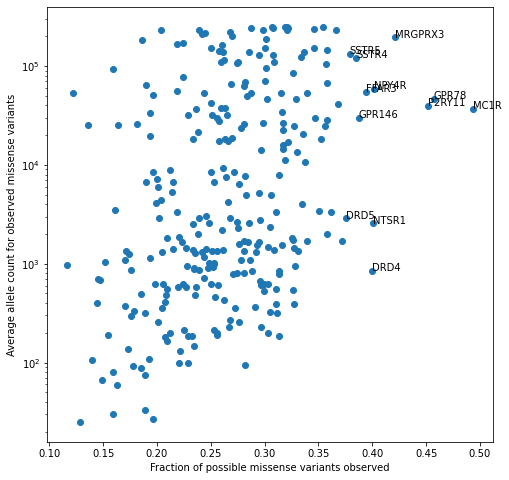

In [64]:
missense_variants_classA = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_missense_labelled_classA.csv',index_col=0)
residue_labels_classA = pd.read_csv('../data/GPCRdb_residue_numbering/GPCRdb_generic_numbers_by_gpcr_residue_ClassA.csv')
counts_by_gene = (missense_variants_classA
    .groupby('HGNC Symbol')
    .agg({'reference_amino_acid':len,'allele_count':max})
    .rename(columns={'reference_amino_acid':'N_unique_variants','allele_count':'N_called_variants'}))
protein_length = residue_labels_classA[['HGNC Symbol']].value_counts().reset_index()
protein_length.columns = ['HGNC Symbol','protein_length']
counts_by_gene = counts_by_gene.merge(protein_length, on='HGNC Symbol')
counts_by_gene['Variant_density'] = counts_by_gene['N_unique_variants'] / (2*counts_by_gene['protein_length'])
counts_by_gene['Average_allele_count'] = counts_by_gene['N_called_variants'] #/ counts_by_gene['protein_length']

fig, ax = plt.subplots(figsize=(8,8))
x = counts_by_gene['Variant_density']
y = counts_by_gene['Average_allele_count']
labels = counts_by_gene['HGNC Symbol']
ax.scatter(x,y)
plt.xlabel('Fraction of possible missense variants observed')
plt.ylabel('Average allele count for observed missense variants')
plt.yscale('log')
for x_, y_, txt in zip(x, y, labels):
    if  x_ > 0.375:
        ax.annotate(txt, (x_,y_))
plt.savefig('../plots/average_missense_allele_count_by_density.png')

<AxesSubplot:xlabel='PolyPhen_numerical', ylabel='Count'>

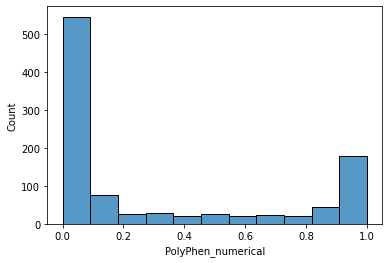

In [47]:
missense_variants_classA = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_missense_labelled_classA.csv',index_col=0)
common_missense_variants_classA = missense_variants_classA[missense_variants_classA.allele_count > 10**-3 * missense_variants_classA.allele_number].copy()
common_missense_variants_classA['PolyPhen_numerical'] = common_missense_variants_classA.PolyPhen.apply(lambda x: float(x.split('(')[-1][:-1]))
sns.histplot(data=common_missense_variants_classA,x ='PolyPhen_numerical')

In [57]:
common_damaging_missense_variants_classA = common_missense_variants_classA[common_missense_variants_classA.PolyPhen_numerical >0.5]
common_damaging_missense_variants_classA= common_damaging_missense_variants_classA[[
    'HGNC Symbol',
    'reference_amino_acid',
    'alternate_amino_acid',
    'sequence_position',
    'GPCRdb_alignment_number',
    'PolyPhen'
]]
common_damaging_missense_variants_classA.to_csv('../data/gnomAD_population_variants/gnomad_common_damaging_missense_variants_classA.csv')

In [58]:
common_damaging_missense_variants_classA['HGNC Symbol'].value_counts()

MC1R      10
MRGPRG     6
NTSR1      6
NMBR       6
GPR84      5
          ..
HTR1E      1
GPR31      1
OPN5       1
PTGER1     1
P2RY2      1
Name: HGNC Symbol, Length: 148, dtype: int64